In [1]:
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras import optimizers
import librosa.display
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import seaborn as sns
from pathlib import Path
import os
import pickle
import IPython.display as ipd
import random
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM, GRU, TimeDistributed
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Convolution2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, Dropout, MaxPool2D
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint
from keras.callbacks import Callback

import sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import librosa
import librosa.display
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import seaborn as sns
from pathlib import Path
import os
import pickle
import IPython.display as ipd
import random
from models.cnn import CNN_model

In [2]:
df_target = pd.read_csv(os.path.abspath('Target_words_dataframe'))
df_unknown = pd.read_csv(os.path.abspath('Unknown_words_dataframe'))
df = pd.read_csv(os.path.abspath('full_df'))

In [3]:
df_target = df_target.drop(columns=['Unnamed: 0'], axis=1)
df_unknown = df_unknown.drop(columns=['Unnamed: 0'], axis=1)

In [4]:
def get_mfcc(path):
    X, sample_rate = librosa.load(path, res_type='kaiser_fast', duration=1, sr=44100, offset=0)
    sample_rate = np.array(sample_rate)
    mfccs = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=30)
    if mfccs.shape[1] < 61:
        b = np.zeros((30, 61 - mfccs.shape[1]))
        mfccs = np.concatenate((mfccs, b), axis=1)
    if mfccs.shape[1] > 61:
        mfccs = mfccs[:, :61]
    mfccs = np.expand_dims(mfccs, axis=0)
    return mfccs

In [19]:
filename = os.path.abspath('../../Data_spotter_mfcc')
outfile = open(filename,'wb')
pickle.dump(X,outfile)
outfile.close()

In [5]:
filename = os.path.abspath('../../Data_spotter_mfcc_40')
outfile = open(filename,'rb')
X = pickle.load(outfile)
outfile.close()

In [6]:
def save_model(Model, model_name):
    save_dir = os.path.join(os.getcwd(), 'saved_models')

    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    model_path = os.path.join(save_dir, model_name)
    Model.save(model_path)
    print('Save model and weights at %s ' % model_path)

    model_json = Model.to_json()
    with open("model_json.json", "w") as json_file:
        json_file.write(model_json)

In [7]:
def save_model_history(model_history, model_history_name):
    filename = 'saved_models_history/' + model_history_name
    outfile = open(filename,'wb')
    pickle.dump(model_history, outfile)
    outfile.close()

In [8]:
class LoggerHistory(keras.callbacks.Callback):
    def __init__(self):
        self.test_loss = []
        self.test_acc = []
        self.train_loss = []
        self.train_acc = []
        
    def on_train_batch_end(self, batch, logs=None):
        if batch % 10 == 0 and batch > 0:
            self.train_loss.append(logs['loss'])
            self.train_acc.append(logs['accuracy'])
        print("\n For train batch {}, loss is {:7.2f}.".format(batch, logs['loss']))
        print("For train batch {}, accuracy is {:7.2f}.".format(batch, logs['accuracy']))

    def on_test_batch_end(self, batch, logs=None):
        if batch % 10 == 0 and batch > 0:
            self.test_loss.append(logs['loss'])
            self.test_acc.append(logs['accuracy'])
        print("\n For test batch {}, loss is {:7.2f}.".format(batch, logs['loss']))
        print("For test batch {}, accuracy is {:7.2f}.".format(batch, logs['accuracy']))

In [9]:
def report(model, X, y, classes):
    model_predictions = model.predict(X).argmax(axis=1)
    true_predictions = y.argmax(axis=1)
    return sklearn.metrics.classification_report(true_predictions, model_predictions, target_names=classes)

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X
                                                    , df.word
                                                    , test_size=0.1
                                                    , shuffle=True
                                                    , random_state=42)

In [11]:
Y_train.value_counts() / len(Y_train)

unknown    0.634494
stop       0.036825
go         0.036791
yes        0.036705
on         0.036705
no         0.036619
off        0.036585
up         0.036482
left       0.036345
right      0.036310
down       0.036139
Name: word, dtype: float64

In [12]:
Y_test.value_counts() / len(Y_test)

unknown    0.630465
down       0.039240
right      0.038931
up         0.038622
no         0.037386
yes        0.036923
left       0.036459
stop       0.036305
on         0.035378
go         0.035378
off        0.034914
Name: word, dtype: float64

In [11]:
print(f'X_train size = {X_train.shape}')
print(f'Y_train size = {Y_train.shape}')
print(f'X_test size = {X_test.shape}')
print(f'Y_test size = {Y_test.shape}')

X_train size = (58248, 40, 61)
Y_train size = (58248,)
X_test size = (6473, 40, 61)
Y_test size = (6473,)


In [14]:
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

In [16]:
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_test = np.array(X_test)
Y_test = np.array(Y_test)

In [16]:
lb = LabelEncoder()
Y_train = np_utils.to_categorical(lb.fit_transform(Y_train))
Y_test = np_utils.to_categorical(lb.fit_transform(Y_test))
print(lb.classes_)

['down' 'go' 'left' 'no' 'off' 'on' 'right' 'stop' 'unknown' 'up' 'yes']


In [17]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))
print(f'X_train size = {X_train.shape}')
print(f'X_test size = {X_test.shape}')

X_train size = (58248, 40, 61, 1)
X_test size = (6473, 40, 61, 1)


In [142]:
model = CNN_model((40, 61, 1), len(lb.classes_))

In [143]:
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 40, 61, 1)]       0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 40, 61, 64)        640       
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 40, 61, 64)        61504     
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 40, 61, 64)        61504     
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 40, 61, 64)        61504     
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 40, 61, 128)       82048     
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 40, 61, 64)        4102

In [144]:
opt = optimizers.Adam(0.001)
model.compile(optimizer = opt, loss='binary_crossentropy', metrics = ["accuracy"])

In [145]:
batch_size = 64

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
train_dataset = train_dataset.batch(batch_size)

# Prepare the validation dataset.
val_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
val_dataset = val_dataset.batch(batch_size)

loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)
train_acc_metric = keras.metrics.BinaryAccuracy()

In [146]:
epochs = 3

test_loss = []
test_acc = []
train_loss = []
train_acc = []

for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))

    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        
        with tf.GradientTape() as tape:
            logits = model(x_batch_train, training=True)
            loss_value = loss_fn(y_batch_train, logits)
        grads = tape.gradient(loss_value, model.trainable_weights)
        opt.apply_gradients(zip(grads, model.trainable_weights))
        
        train_acc_metric.update_state(y_batch_train, logits)
        # Log every 50 batches.
        if step % 50 == 0 and step > 0:
            test_loss_acc = model.evaluate(X_test, Y_test)
            train_loss_acc = float(loss_value), float(train_acc_metric.result()) 
            test_loss.append(test_loss_acc[0])
            test_acc.append(test_loss_acc[1])
            train_loss.append(train_loss_acc[0])
            train_acc.append(train_loss_acc[1])
            print("Current step: %d" % step)
            print("Test loss and acc: %.4f %.4f" % (test_loss_acc[0], test_loss_acc[1]))
            print("Training loss and acc: %.4f %.4f" % (float(train_loss_acc[0]), float(train_loss_acc[1])))
            print("Seen so far: %s samples" % ((step + 1) * batch_size))
    train_acc_metric.reset_states()


Start of epoch 0
203/203 [==============================] - 54s 263ms/step - loss: 0.2010 - accuracy: 0.6424
Current step: 50
Test loss and acc: 0.2054 0.6305
Training loss and acc: 0.2243 0.9350
Seen so far: 3264 samples
203/203 [==============================] - 52s 259ms/step - loss: 0.2048 - accuracy: 0.6305
Current step: 100
Test loss and acc: 0.2048 0.6305
Training loss and acc: 0.2092 0.9351
Seen so far: 6464 samples
203/203 [==============================] - 53s 261ms/step - loss: 0.2085 - accuracy: 0.6305
Current step: 150
Test loss and acc: 0.2085 0.6305
Training loss and acc: 0.1951 0.9350
Seen so far: 9664 samples
203/203 [==============================] - 51s 253ms/step - loss: 0.2061 - accuracy: 0.6305
Current step: 200
Test loss and acc: 0.2061 0.6305
Training loss and acc: 0.1907 0.9342
Seen so far: 12864 samples
203/203 [==============================] - 52s 258ms/step - loss: 0.2062 - accuracy: 0.6305
Current step: 250
Test loss and acc: 0.2062 0.6305
Training loss a

In [149]:
save_model(model, "CNN_without_spec_auc")

INFO:tensorflow:Assets written to: /Users/mbassalaev/Desktop/audio_project/Spotter_recognition/saved_models/CNN_without_spec_auc/assets
Save model and weights at /Users/mbassalaev/Desktop/audio_project/Spotter_recognition/saved_models/CNN_without_spec_auc 


In [167]:
save_model_history((train_loss, test_loss), "CNN_without_spec_auc")

In [22]:
# classification report sklearn
# посмотреть на чем обучают в kws_streaming
# убрать оффсет
# добавить аргументаций, дропауты?
# посмотреть как ошибка распределена по классам, (сбалансировать X_test, Y_test)

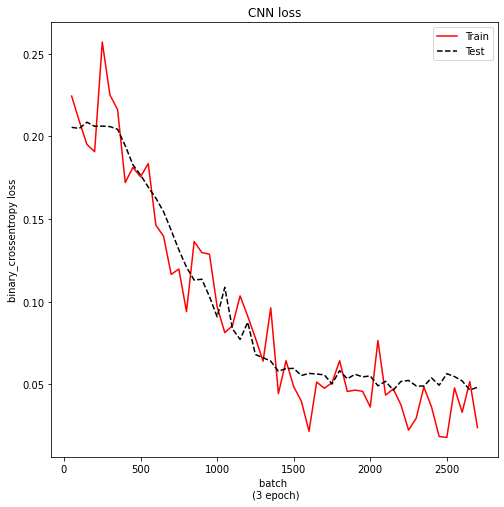

In [166]:
plt.figure(figsize=(8,8))
train_plot = plt.plot(temp, train_loss, color='red', label='Train')
test_plot = plt.plot(temp, test_loss, color='black', linestyle='dashed', label='Test')
plt.title('CNN loss')
plt.ylabel('binary_crossentropy loss')
plt.xlabel('batch \n (3 epoch)')
plt.legend(loc='upper right')
plt.savefig("CNN_withou_spec_auc")
plt.show()

In [79]:
print(report(model, X_test, Y_test, lb.classes_))

              precision    recall  f1-score   support

        down       0.94      0.73      0.82       254
          go       0.90      0.78      0.84       229
        left       0.93      0.81      0.86       236
          no       0.78      0.87      0.83       242
         off       0.85      0.82      0.83       226
          on       0.94      0.73      0.82       229
       right       0.96      0.78      0.86       252
        stop       0.94      0.90      0.92       235
     unknown       0.92      0.98      0.95      4081
          up       0.82      0.78      0.80       250
         yes       0.96      0.90      0.93       239

    accuracy                           0.91      6473
   macro avg       0.90      0.82      0.86      6473
weighted avg       0.91      0.91      0.91      6473

